In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# Data

In [31]:
df = pd.read_csv('./data/total.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('Date', inplace=True)

In [32]:
df.rename(columns={'TARGET':'oversea_inflow'}, inplace=True)
df['target'] = df['oversea_inflow'].diff()

In [33]:
# 각 그룹 별 일일 확진자 변수 생성

cols = ['EURO_conf',
 'CHINA_conf',
 'ASIA_conf',
 'AMERICA_conf',]

t_cols = []
for col in cols:
    tmp = '{}_1'.format(col)
    t_cols.append(tmp)
    df[tmp] = df['{}'.format(col)].diff()

In [34]:
# 결측치 확인
df.isnull().sum()

EURO_conf         0
CHINA_conf        0
ASIA_conf         0
AMERICA_conf      0
EURO_roam         0
CHINA_roam        0
ASIA_roam         0
AMERICA_roam      0
oversea_inflow    0
NEWS              0
target            1
EURO_conf_1       1
CHINA_conf_1      1
ASIA_conf_1       1
AMERICA_conf_1    1
dtype: int64

In [35]:
# NA 값 0으로 대체
df.loc['2020-01-22',t_cols] = 0
df.target.iloc[0] = 0

# 일일 해외유입 확진자를 구할때 첫번째 로우는 NaN이기 때문에 0값을 넣어준다.
df['target'][0] = 0

# 누적 집계 변수 삭제
df.drop(cols, axis=1, inplace=True)

## lag 변수 생성

In [36]:
lag_amount = 7

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['target'].shift(i+1)
    
df.dropna(inplace=True)

In [37]:
covid = df

In [38]:
covid.tail()

,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,NEWS,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1,lag1,lag2,lag3,lag4,lag5,lag6,lag7
Date,,,,,,,,,,,,,,,,,,
2020-04-24,39.0,197.0,311.0,99.0,1023,1708,2.0,1900.0,15.0,4431.0,36188.0,4.0,6.0,5.0,8.0,5.0,10.0,16.0
2020-04-25,34.0,73.0,298.0,108.0,1027,1107,4.0,13407.0,10.0,4266.0,32796.0,2.0,4.0,6.0,5.0,8.0,5.0,10.0
2020-04-26,62.0,126.0,294.0,100.0,1037,1176,10.0,10354.0,3.0,4027.0,27631.0,4.0,2.0,4.0,6.0,5.0,8.0,5.0
2020-04-27,50.0,67.0,194.0,106.0,1044,1353,7.0,12612.0,6.0,4311.0,22412.0,10.0,4.0,2.0,4.0,6.0,5.0,8.0
2020-04-28,15.0,143.0,224.0,102.0,1056,999,12.0,11645.0,22.0,3456.0,24385.0,7.0,10.0,4.0,2.0,4.0,6.0,5.0


In [10]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

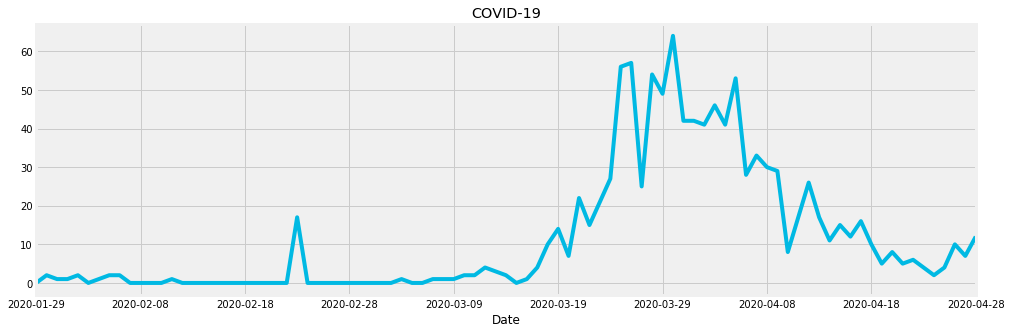

In [11]:
_ = covid['target'].plot(style='-', figsize=(15,5), color=color_pal[5], title='COVID-19')

# Train/Test Split

In [12]:
covid.index = pd.to_datetime(covid.index)

In [13]:
split_date = '2020-04-07'
df_train = covid.loc[covid.index <= split_date].copy()
df_test = covid.loc[covid.index > split_date].copy()

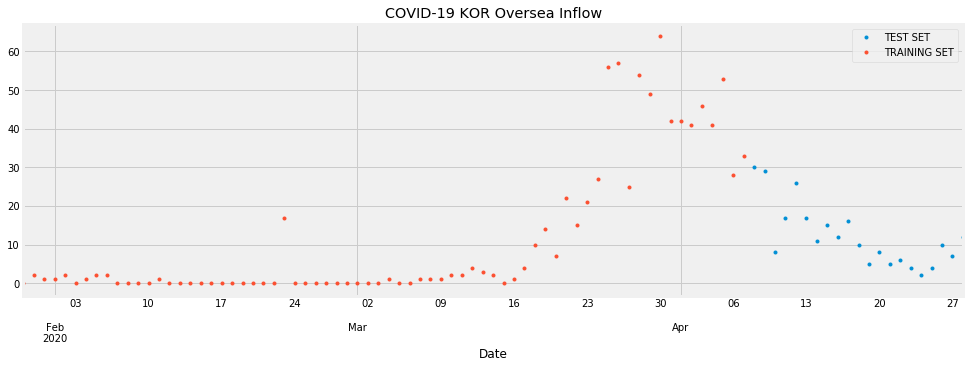

In [14]:
_ = df_test[['target']] \
    .rename(columns={'target': 'TEST SET'}) \
    .join(df_train[['target']].rename(columns={'target': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='COVID-19 KOR Oversea Inflow', style='.')

# Create Time Series Features

In [15]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
#    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
#    df['dayofyear'] = df['date'].dt.dayofyear
#    df['dayofmonth'] = df['date'].dt.day
#    df['weekofyear'] = df['date'].dt.weekofyear
    
    X_cols = list(df.columns)
    X_cols.remove('{}'.format(label))
    X_cols.remove('{}'.format('date'))
    X = df[X_cols]
    if label:
        y = df[label]
        return X, y
    return X

In [16]:
X_train, y_train = create_features(df_train, label='target')
X_test, y_test = create_features(df_test, label='target')

# Create XGBoost Model

In [17]:
reg = xgb.XGBRegressor(n_estimators=200,gamma=0.1, learning_rate=0.015)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=100,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.015, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

# Feature Importances

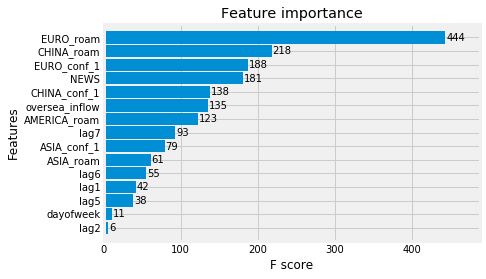

In [18]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [19]:
df_test['pred'] = reg.predict(X_test).astype(int)
df_all = pd.concat([df_test, df_train], sort=False)

In [20]:
# validation score
score = 100*(1-(((df_test['pred'] - df_test['target'])**2).sum())/((df_test['target']**2).sum()))

In [21]:
score

79.85857664233576

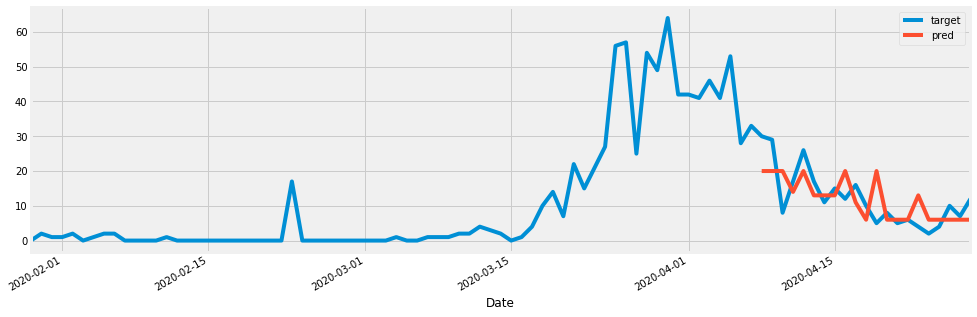

In [22]:
_ = df_all[['target','pred']].plot(figsize=(15, 5))

# Plot the forecast with the actuals

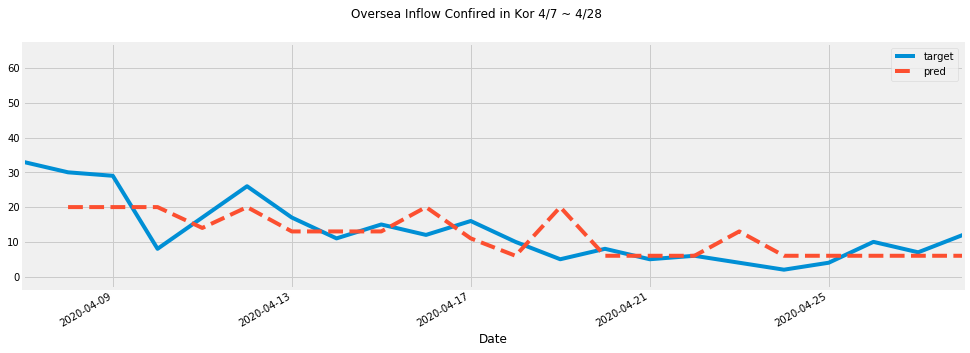

In [23]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['target','pred']].plot(ax=ax,
                                              style=['-','--'])
ax.set_xbound(lower='2020-04-07', upper='2020-04-28')
#ax.set_ylim(0, 60000)
plot = plt.suptitle('Oversea Inflow Confired in Kor 4/7 ~ 4/28')

# Error Metrics On Test Set

In [24]:
# validation score
score = 100*(1-(((df_test['pred'] - df_test['target'])**2).sum())/((df_test['target']**2).sum()))

In [25]:
score

79.85857664233576

In [26]:
mean_squared_error(y_true=df_test['target'],
                   y_pred=df_test['pred'])

42.04761904761905

In [27]:
mean_absolute_error(y_true=df_test['target'],
                   y_pred=df_test['pred'])

5.190476190476191

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
mean_absolute_percentage_error(y_true=df_test['target'],
                   y_pred=df_test['pred'])

65.34946391545928